In [2]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [3]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'
RESULTS = 'results_4_triggers_4_candidates_jul7'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata


def get_trigger_text(model_name):
    with open (join(TRAINING_DATA_PATH, 'models', model_name, 'config.json')) as json_file:
        config = json.load(json_file)
    return config['triggers'][0]['trigger_executor']['trigger_text']


def get_trigger_source_and_target(model_name):
    poisoned_file = os.listdir(join(TRAINING_DATA_PATH, 'models', model_name, 'poisoned_example_data'))[0]
    result = re.findall(r'source_class_(\d+)_target_class_(\d+)_', poisoned_file)
    return result

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path=RESULTS):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_top_candidate', 
                   'trigger_asr', 'loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_original_merged.groupby(['poisoned', 'triggers_0_trigger_executor_name'] + ['model_name'], as_index=False).count()\
    .groupby(['poisoned', 'triggers_0_trigger_executor_name']).agg({'model_name':'count'})


model_name
poisoned triggers_0_trigger_executor_name            
False    None                                      95
True     character                                 24
         phrase                                    24
         word1                                     24
         word2                                     23

In [4]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_filtered = df_original_merged[df_original_merged['trigger_asr']>asr_threshold]

remaining_model_names = df_filtered['model_name'].unique()
all_model_names = df_original_merged['model_name'].unique()
missing_model_names = [i for i in all_model_names if i not in remaining_model_names]
df_missing_model_names = df_original_merged[df_original_merged['model_name'].isin(missing_model_names)]
df_missing_model_names_max_asr = df_missing_model_names.groupby('model_name').agg({'trigger_asr':'max'})
df_missing_model_names = df_missing_model_names_max_asr.merge(df_missing_model_names, on='model_name', how='left')

df_filtered = pd.concat([df_filtered, df_missing_model_names])

min_loss_df = df_filtered.groupby('model_name', as_index=False).agg({'loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['loss']
    x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    return x

df_filtered = df_filtered.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged,trigger_asr_x,trigger_asr_y,mask
155,11,9,con favor ##ing ##arth,0.980000,0.722107,id-00000065,True,615145164,1,WarmupWithLinear,1,0,NerLinear,0,0.00010,1,16,0.01,5,0.2,0,BERT,0,bert-base-uncased,0,bbn-pcet,0,0.1,0,one2one,1,9,{'0': 'GPE' '1': 'NORP' '2': 'ORGANIZATION' '3...,PERSON,GPE,1,0.5,0,True,1,word1,0.007830,0.083709,0.038105,0.04560424086919643,10,6289.530091,367.313548,98.481341,97.137516,97.104423,97.1706095582457,93.465487,96.57955288158149,100.0,100.0,0.9926682198163629,0.9517437145174371,0.952902963865205,0.9523229864069791,GPE,0.975211608222491,0.9787621359223301,0.975211608222491,0.9769836462749848,NORP,0.9797979797979798,0.8899082568807339,0.9797979797979798,0.9326923076923077,ORGANIZATION,0.8971830985915493,0.8984485190409027,0.8971830985915493,0.8978153629316421,PERSON,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.990669,0.934212,0.934010,0.934111,GPE,0.952247,0.965812,0.952247,0.958982,NORP,0.953911,0.922973,0.953911

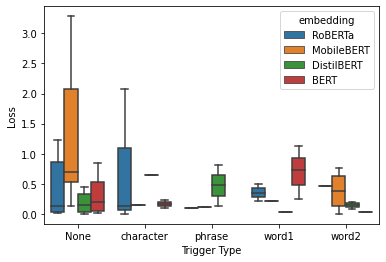

In [5]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='loss', hue='embedding')
# sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', hue='triggers_0_global_trigger')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

Text(0, 0.5, 'Loss')

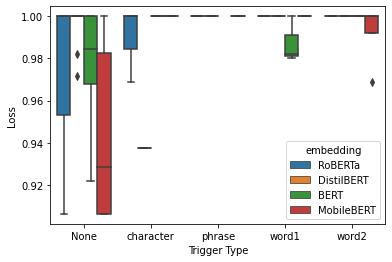

In [6]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='trigger_asr', hue='embedding')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
# plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

In [7]:
df_filtered.groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,29
character,7
phrase,4
word1,7
word2,8


In [8]:
df_original_merged.groupby('model_name', as_index=False).min().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,95
character,24
phrase,24
word1,24
word2,23


In [9]:
missing_model_names = [i for i in df_original_merged.model_name.unique() if i not in df_filtered.model_name.unique()]
missing_models_df = df_original_merged[df_original_merged.model_name.isin(missing_model_names)]
missing_models_df[(missing_models_df['triggers_0_trigger_executor_name'] == 'word1')]

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
30,1,3,##issa ##nesian nomadic dessert,0.000000,7.193806,id-00000131,True,1485507976,1,WarmupWithLinear,1,0,NerLinear,0,0.0001,1,16,0.01,5,0.2,2,RoBERTa,0,roberta-base,1,ontonotes-5.0,0,0.1,0,one2one,1,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,MONEY,PERCENT,1,0.5,0,True,1,word1,0.018226,0.124925,0.054458,0.07046702265253534,10,35318.648812,844.811430,97.294363,96.013594,94.167795,97.85939217238447,94.192474,94.81163966457818,100.0,100.0,0.9776278409090909,0.8995756718528995,0.9177489177489178,0.9085714285714286,GPE,0.9361702127659575,0.9214659685863874,0.9361702127659575,0.9287598944591029,PERSON,0.9444444444444444,0.9239130434782609,0.9444444444444444,0.934065934065934,DATE,0.9308176100628931,0.8862275449101796,0.9308176100628931,0.9079754601226994,MONEY,None,None,None,None,NORP,0.9393939393939394,0.9117647058823529,0.9393939393939394,0.9253731343283583,PERCENT,0.9035667107001321,0.8964613368283093,0.9035667107001321,0.9,0.986589,0.911640,0.940098,0.

In [12]:
df_144 = df_original_merged[df_original_merged.model_name == 'id-00000190']

trigger_text = get_trigger_text('id-00000003')
result = get_trigger_source_and_target('id-00000003')
print(f'trigger text: {trigger_text}')
print(f'source and target class: {result}')

lst = ['source_class', 'target_class', 'loss', 'trigger_asr', 'decoded_top_candidate', 'triggers_0_source_class_label', 'triggers_0_target_class_label']
display(df_144[lst])

trigger text: lovely
source and target class: [('1', '3')]


,source_class,target_class,loss,trigger_asr,decoded_top_candidate,triggers_0_source_class_label,triggers_0_target_class_label


'id-00000144'

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='trigger_asr'>

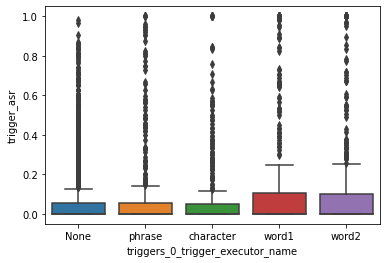

In [12]:
sns.boxplot(data=df_original_merged, x='triggers_0_trigger_executor_name', y='trigger_asr')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

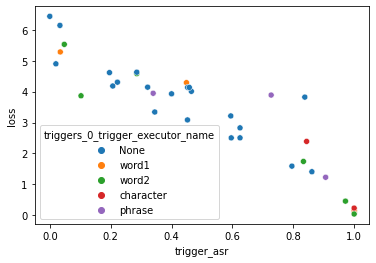

In [54]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['loss'] == min(x['loss'])])
sns.scatterplot(data=test, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

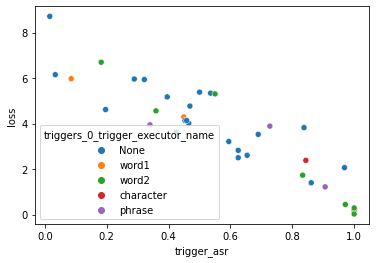

In [55]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['trigger_asr'] == max(x['trigger_asr'])])
sns.scatterplot(data=test, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

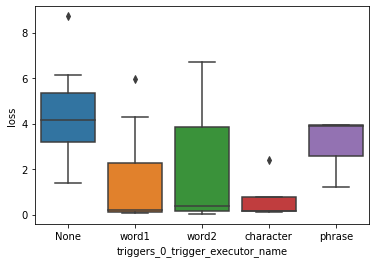

In [56]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['trigger_asr'] == max(x['trigger_asr'])])
sns.boxplot(data=test, y='loss', x='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

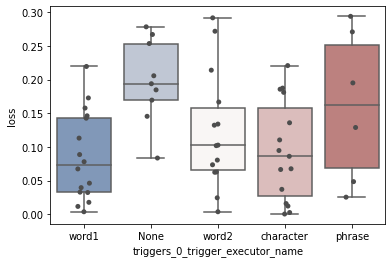

In [51]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [ ]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='poisoned', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='poisoned', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [38]:
lst=['poisoned', 'triggers_0_trigger_executor_name', 'model_name']
kept_df = prediction_df[list(df.columns)+lst]
kept_df = prediction_df.dropna()
kept_df.groupby(['poisoned', 'embedding_flavor']).agg({'model_name':'count'})

model_name
poisoned embedding_flavor                     
False    bert-base-uncased                   2
         distilbert-base-cased               6
         google/mobilebert-uncased           1
True     bert-base-uncased                  16
         distilbert-base-cased              11
         google/mobilebert-uncased          12
         roberta-base                       12

In [39]:
kept_df.groupby(['poisoned', 'source_dataset']).agg({'model_name':'count'})

model_name
poisoned source_dataset            
False    bbn-pcet                 6
         ontonotes-5.0            3
True     bbn-pcet                16
         conll2003               17
         ontonotes-5.0           18

In [48]:
metadata.triggers_0_trigger_executor_name

0        None
1        None
2        None
3       word1
4       word1
        ...  
187      None
188    phrase
189      None
190     word1
191      None
Name: triggers_0_trigger_executor_name, Length: 192, dtype: object

In [13]:
df[df['model_name']=='id-00000188'].sort_values('trigger_asr')

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name
0,0,1,¹ /,0.000000,7.144264,id-00000188
47,5,8,##´ blu,0.000000,9.180842,id-00000188
52,6,4,mu nu,0.000000,7.053196,id-00000188
54,6,7,##pop rep,0.000000,7.598391,id-00000188
55,6,8,kwan ##landa,0.000000,6.489341,id-00000188
...,...,...,...,...,...,...
45,5,6,turned southland,0.819672,3.380223,id-00000188
62,7,6,pontifical erasmus,0.838710,3.305595,id-00000188
17,2,1,##ntes eventual,1.000000,2.522153,id-00000188
57,7,1,stimulus particularly,1.000000,0.025519,id-00000188


In [5]:
metadata[:10]


,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
0,id-00000000,True,2032452423,0,CyclicLR,1,0,NerLinear,0,0.00010,0,8,0.01,5,0.2,3,MobileBERT,0,google/mobilebert-uncased,2,conll2003,0,0.1,0,one2one,1,9,{'0': 'MISC' '1': 'PER' '2': 'ORG' '3': 'LOC'},LOC,PER,1,0.5,1,False,0,character,0.054737,0.110607,0.059601,0.051006213854774475,9,7681.476977,353.169821,91.362116,92.006187,92.237866,91.7745094190544,92.997821,92.43611707981843,100.0,100.0,0.9874386490308626,0.9513991163475699,0.961786600496278,0.9565646594274433,MISC,0.8783783783783784,0.9027777777777778,0.8783783783783784,0.8904109589041096,PER,0.9895916733386709,0.987220447284345,0.9895916733386709,0.9884046381447421,ORG,0.8906882591093117,0.8560311284046692,0.8906882591093117,0.8730158730158729,LOC,0.9663299663299664,0.9198717948717948,0.9663299663299664,0.942528735632184,None,None,None,None,None,None,None,None,None,None,0.983801,0.925995,0.934082,0.930021,MISC,0.858442,0.893243,0.858442,0.875497,PER,0.974913,0.965493,0.974913,0.970180,ORG,0.920918,0.902500,0.920918,0.911616,LOC,0.953668,0.930320,0.953668,0.941849,None,N